<a href="https://colab.research.google.com/github/demolakstate/anomaly_detection_sport_video/blob/main/Detecting_risky_tackles_in_sport_videos_using_Transformer_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Classification with Transformers

**Description:** Training a video classifier with hybrid transformers.

This example is a follow-up to the
[Video Classification with a CNN-RNN Architecture](https://keras.io/examples/vision/video_classification/)
example. This time, we will be using a Transformer-based model
([Vaswani et al.](https://arxiv.org/abs/1706.03762)) to classify videos. You can follow
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11)
in case you need an introduction to Transformers (with code). After reading this
example, you will know how to develop hybrid Transformer-based models for video
classification that operate on CNN feature maps.

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

## Data collection

In [1]:
# Connect to drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Setup

In [2]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [3]:
from google.colab.patches import cv2_imshow

## Define hyperparameters

In [23]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 1920 #128

EPOCHS = 100

## Data preparation

We will mostly be following the same data preparation steps in this example, except for
the following changes:

* We reduce the image size to 128x128 instead of 224x224 to speed up computation.
* Instead of using a pre-trained [InceptionV3](https://arxiv.org/abs/1512.00567) network,
we use a pre-trained
[DenseNet121](http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf)
for feature extraction.
* We directly pad shorter videos to length `MAX_SEQ_LENGTH`.

First, let's load up the
[DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [5]:

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)

def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped

## Data visualization

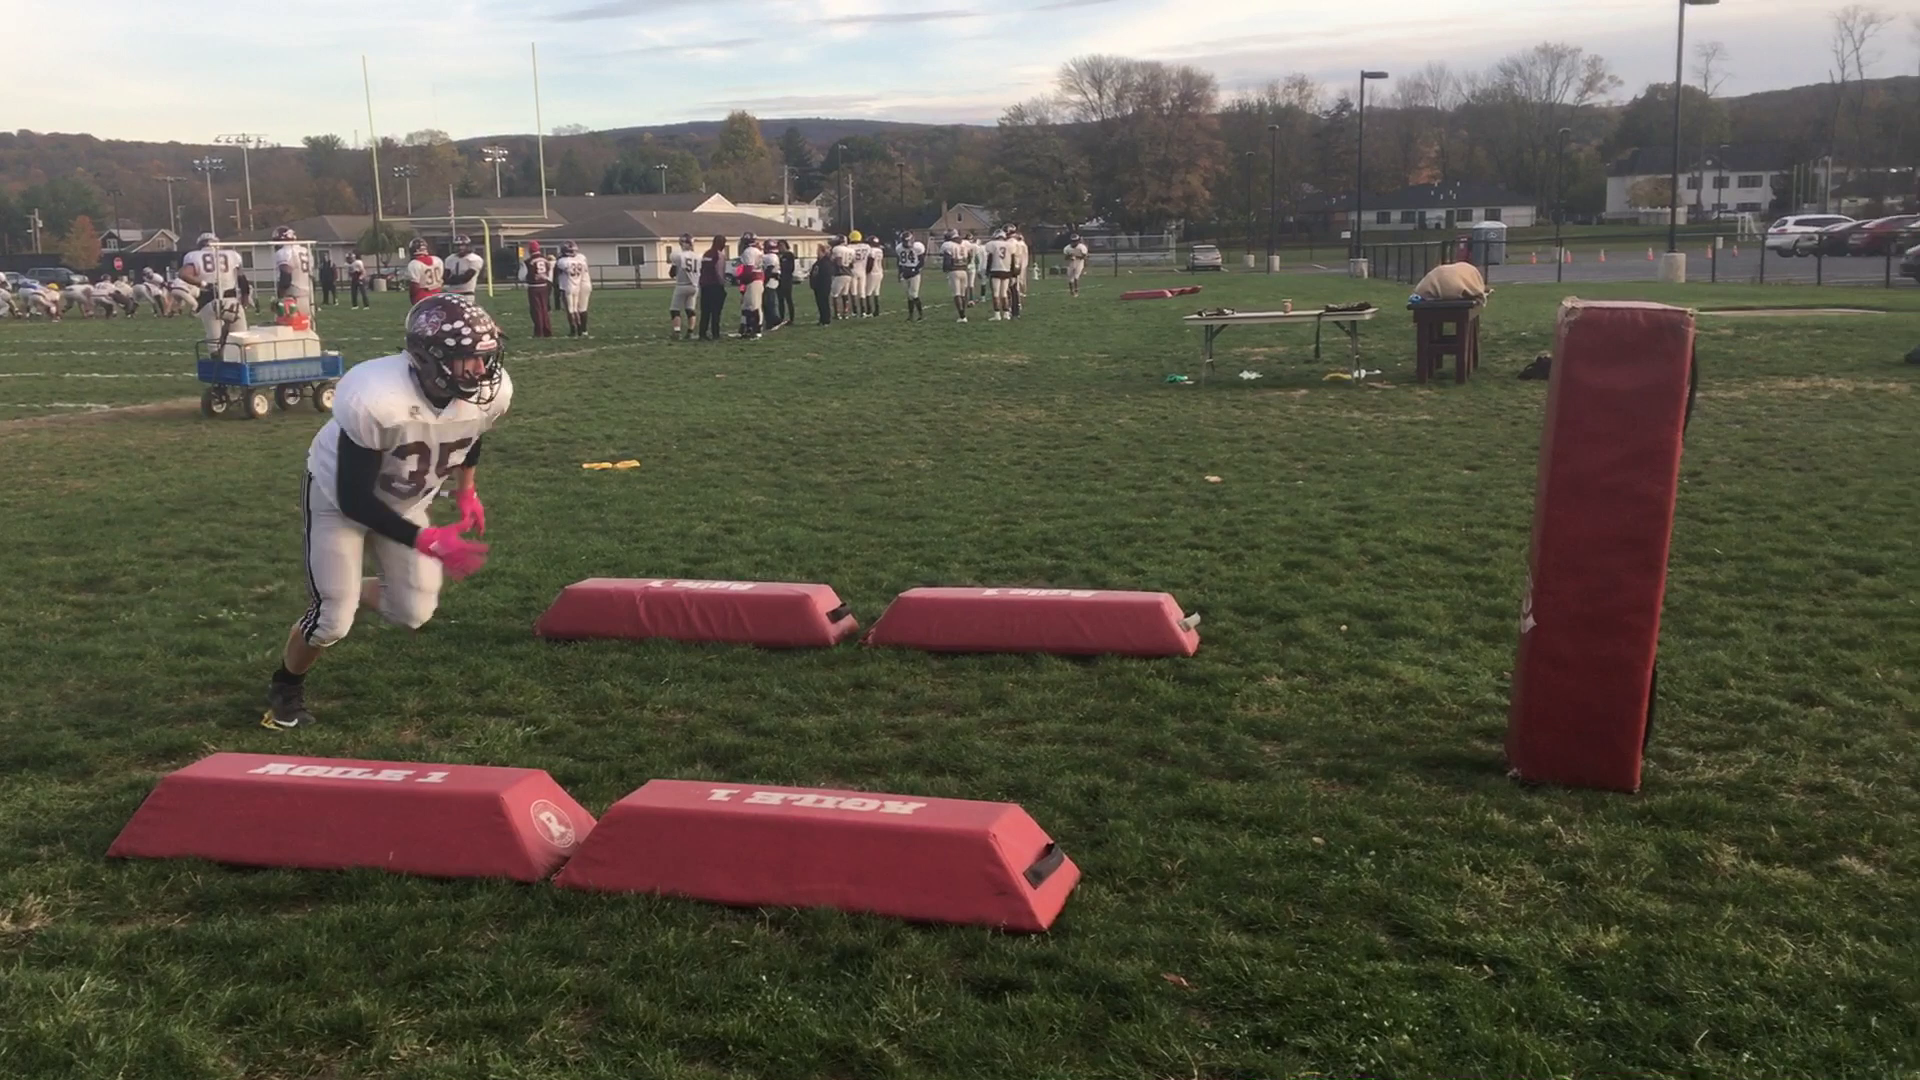

(1920, 1920, 3)


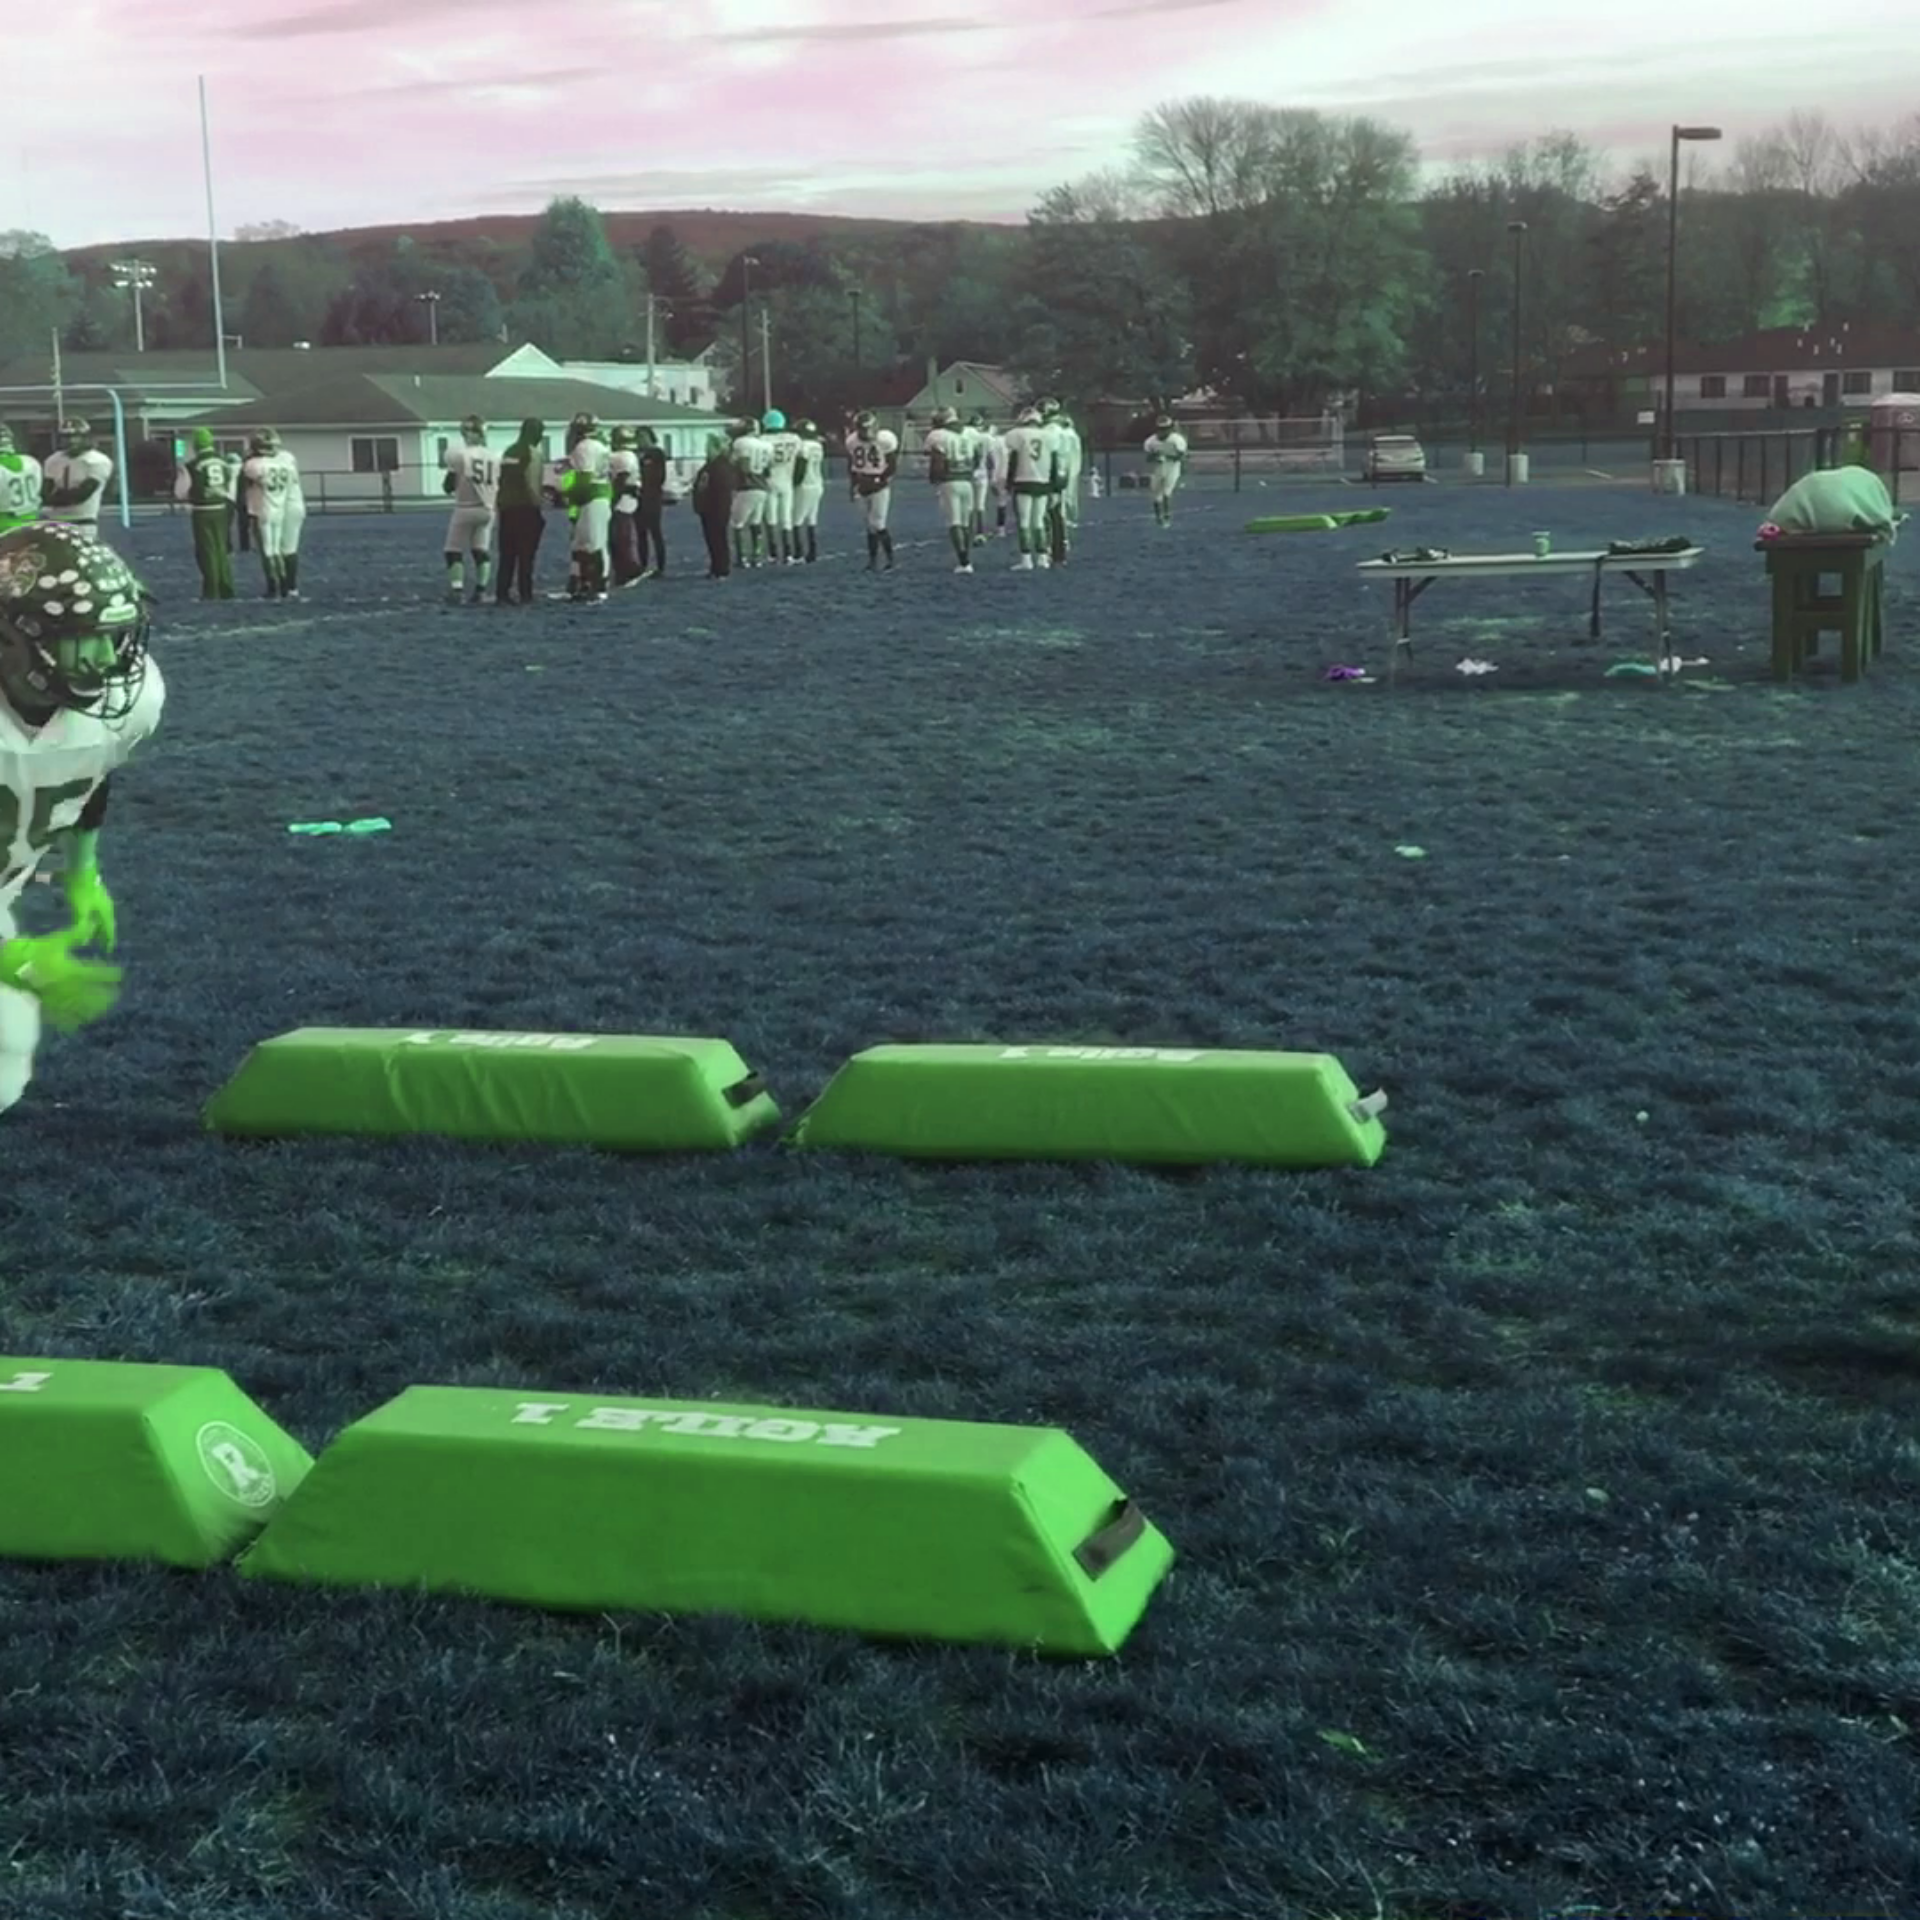

In [6]:
cap = cv2.VideoCapture('/content/gdrive/MyDrive/ksutackle_dataset/risky_7.mp4')

while True:
  try:
    ret, frame = cap.read()
    if not ret:
      break
    cv2_imshow(frame)
    frame = crop_center(frame)
    #cv2_imshow(frame)
    frame = frame[:,:,[1,2,0]]
    print(frame.shape)
    cv2_imshow(frame)


  finally:
    cap.release()

In [7]:
# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            #frame = crop_center(frame)
            frame = cv2.resize(frame, (IMG_SIZE,IMG_SIZE))
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)



In [8]:
def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [9]:
# Label preprocessing with StringLookup.
label_tag = ['risky', 'safe']
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(label_tag), mask_token=None
)
print(label_processor.get_vocabulary())


['risky', 'safe']


In [10]:
label_processor(label_tag).numpy()

array([0, 1])

In [26]:
def prepare_all_videos(root_dir):
    
    video_paths = os.listdir('/content/gdrive/MyDrive/ksutackle_dataset')[:50]
    labels = [video_path.split('_')[0] for video_path in video_paths][:50]
    num_samples = len(labels)
    #labels = label_processor(labels[..., None]).numpy()

    labels = label_processor(labels).numpy()
    print('labels: ', labels)

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


In [27]:
train_data, train_labels = prepare_all_videos('/content/gdrive/MyDrive/ksutackle_dataset')

labels:  [0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 0 0]


In [28]:
print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (50, 20, 1024)


## Building the Transformer-based model

We will be building on top of the code shared in
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11) of
[Deep Learning with Python (Second ed.)](https://www.manning.com/books/deep-learning-with-python)
by François Chollet.

First, self-attention layers that form the basic blocks of a Transformer are
order-agnostic. Since videos are ordered sequences of frames, we need our
Transformer model to take into account order information.
We do this via **positional encoding**.
We simply embed the positions of the frames present inside videos with an
[`Embedding` layer](https://keras.io/api/layers/core_layers/embedding). We then
add these positional embeddings to the precomputed CNN feature maps.

In [29]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask


Now, we can create a subclassed layer for the Transformer.

In [30]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


## Utility functions for training

In [31]:

def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    # _, accuracy = model.evaluate(train_data, train_labels)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model


## Model training and inference

In [32]:
trained_model = run_experiment()

Epoch 1/100
1/2 [==============>...............] - ETA: 1s - loss: 0.6617 - accuracy: 0.6562
Epoch 00001: val_loss improved from inf to 1.40729, saving model to /tmp/video_classifier
2/2 [==============================] - 2s 443ms/step - loss: 1.8744 - accuracy: 0.6667 - val_loss: 1.4073 - val_accuracy: 0.6250
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 1.3038 - accuracy: 0.6562
Epoch 00002: val_loss did not improve from 1.40729
2/2 [==============================] - 0s 32ms/step - loss: 3.3075 - accuracy: 0.6667 - val_loss: 4.9616 - val_accuracy: 0.6250
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 5.1298 - accuracy: 0.6562
Epoch 00003: val_loss did not improve from 1.40729
2/2 [==============================] - 0s 32ms/step - loss: 4.0788 - accuracy: 0.6667 - val_loss: 2.2283 - val_accuracy: 0.6250
Epoch 4/100
1/2 [==============>...............] - ETA: 0s - loss: 1.8388 - accuracy: 0.6875
Epoch 00004: val_loss did not improve from 1.40729


**Note**: This model has ~4.23 Million parameters, which is way more than the sequence
model (99918 parameters) we used in the prequel of this example.  This kind of
Transformer model works best with a larger dataset and a longer pre-training schedule.

In [33]:
--

SyntaxError: ignored

In [ ]:

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

The performance of our model is far from optimal, because it was trained on a
small dataset.